In [ ]:
pip install -r requirements.txt

In [1]:
# Import needed packages 
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# import some needed packages for deep neural networks
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import random


/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Fields:

image: the image id

image: PIL.Image.Image object containing the image. Note that when accessing the image column: dataset[0]["image"] the image file is automatically decoded. Decoding of a large number of image files might take a significant amount of time. Thus it is important to first query the sample index before the "image" column, i.e. dataset[0]["image"] should always be preferred over dataset["image"][0]

width: the image width

height: the image height

objects: a dictionary containing bounding box metadata for the objects present on the image

id: the annotation id

area: the area of the bounding box

bbox: the object's bounding box (in the coco format)

category: the object's category, with possible values including 

Coverall (0),Face_Shield (1),Gloves (2),Goggles (3) and Mask (4)

In [2]:
# Visualize the json file correspond to the first image in dataset
dataset = load_dataset('cppe-5', split='train')

Using custom data configuration default
Found cached dataset cppe-5 (/home/shahriar/.cache/huggingface/datasets/cppe-5/default/1.0.0/e73c6e117c246296b2a4fcc0863ba3de20c44db01096b66394e85764203f66e4)


In [3]:
# Visualize the json file representing the info for the first image in dataset
dataset[0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

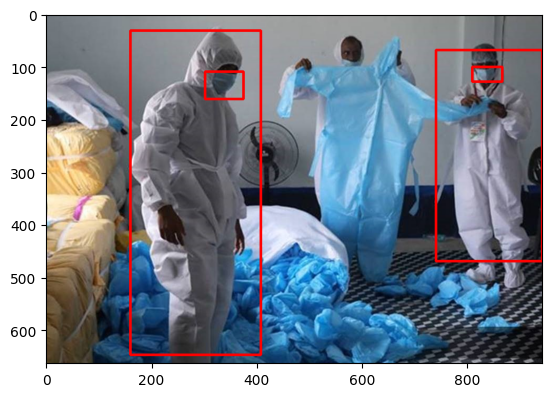

In [4]:
# Visualize the first image in dataset and the bboxs
image = dataset[0]['image']
img = Image.frombytes("RGB", (dataset[0]['width'], dataset[0]['height']), image.tobytes())
cv_image = np.array(img)
for counter in range(len(dataset[0]['objects']['id'])):
    xmin = dataset[0]['objects']['bbox'][counter][0]
    ymin = dataset[0]['objects']['bbox'][counter][1]
    xmax = xmin + dataset[0]['objects']['bbox'][counter][2]
    ymax = ymin + dataset[0]['objects']['bbox'][counter][3]
    draw_img = cv2.rectangle(cv_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
    
plt.imshow(draw_img)
plt.show()

In [5]:
# Create CSV file for training dataset from json files
train_csv_list = []
columns = ['image_id', 'width', 'height', 'xmin', 'ymin', 'bbox_width', 'bbox_height', 'id', 'area', 'category']
for i in range(len(dataset)):
    record = dataset[i]
    image_id = record['image_id']
    width = record['width']
    height = record['height']
    for j in range(len(record['objects']['id'])):
        
        xmin = record['objects']['bbox'][j][0]
        ymin = record['objects']['bbox'][j][1]
        bbox_width = record['objects']['bbox'][j][0] + record['objects']['bbox'][j][2]
        bbox_height = record['objects']['bbox'][j][1] + record['objects']['bbox'][j][3]
        id = record['objects']['id'][j]
        area = record['objects']['area'][j]
        category = record['objects']['category'][j]
    
        row = (image_id, width, height, xmin, ymin, bbox_width, bbox_height, id, area, category)
        train_csv_list.append(row)
    if i % 100 == 0:
        print("{} images have been processed".format(i))
train_csv = pd.DataFrame(train_csv_list, columns=columns)

0 images have been processed
100 images have been processed
200 images have been processed
300 images have been processed
400 images have been processed
500 images have been processed
600 images have been processed
700 images have been processed
800 images have been processed
900 images have been processed


In [6]:
# Shape of CSV file 
# This datset contains 4491 bounding box. We have 10 feature to describe each image.
train_csv.shape

(4491, 10)

In [7]:
# Disply the first 10 record of dataset 
train_csv.head(10)

,image_id,width,height,xmin,ymin,bbox_width,bbox_height,id,area,category
0,15,943,663,302.0,109.0,375.0,161.0,114,3796,4
1,15,943,663,810.0,100.0,867.0,128.0,115,1596,4
2,15,943,663,160.0,31.0,408.0,647.0,116,152768,0
3,15,943,663,741.0,68.0,943.0,469.0,117,81002,0
4,762,1200,1200,182.0,492.0,322.0,619.0,3403,17780,4
5,762,1200,1200,514.0,483.0,689.0,583.0,3404,17500,4
6,762,1200,1200,1042.0,483.0,1166.0,577.0,3405,11656,4
7,762,1200,1200,463.0,811.0,611.0,901.0,3406,13320,2
8,762,1200,1200,287.0,905.0,357.0,930.0,3407,1750,2
9,762,1200,1200,344.0,908.0,460.0,1004.0,3408,11136,2


In [8]:
train_csv.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4491 entries, 0 to 4490
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_id     4491 non-null   int64  
 1   width        4491 non-null   int64  
 2   height       4491 non-null   int64  
 3   xmin         4491 non-null   float64
 4   ymin         4491 non-null   float64
 5   bbox_width   4491 non-null   float64
 6   bbox_height  4491 non-null   float64
 7   id           4491 non-null   int64  
 8   area         4491 non-null   int64  
 9   category     4491 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 351.0 KB


In [9]:
# To see if any image_id used more than once  
train_csv['image_id'].duplicated().any()

True

In [10]:
# Find the the unique number of images. 
# Number of images 1000
# number of bounding boxes 4491
train_csv.groupby('image_id').size().count()

1000

In [11]:
# To Find how many object detected in each class/category.
 
label_group_df=train_csv[['image_id','category']].groupby(['category']).count().reset_index()
label_group_df.columns=['category','count']
label_group_df=label_group_df.sort_values(by=['count'],ascending=False)
label_group_df

# 1152 detection in class Coverall (0)
# 430 detection in class Coverall (1)
# 1282 detection in class Coverall (2)
# 375 detection in class Coverall (3)
# 1252 detection in class Coverall (4)

,category,count
2,2,1282
4,4,1252
0,0,1152
1,1,430
3,3,375


In [12]:
print('Number of unique category: ',label_group_df.shape[0])

Number of unique category:  5


In [13]:
#analyzing duplicate label_group
var=train_csv[train_csv["category"].duplicated() == True].shape[0]
print('Number of duplicated category: ',var)

Number of duplicated category:  4486


In [14]:
# To see how many images have more one detected object/boundingbox
var=train_csv[train_csv["image_id"].duplicated() == True].shape[0]
print('Number of duplicated image_id: ',var)

Number of duplicated image_id:  3491


/tmp/ipykernel_219473/3045177517.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.barplot(x=label_group_df['category'][:50],y=label_group_df['count'][:50])


Text(0.5, 1.0, 'Number of pictures in same label for first 50 category')

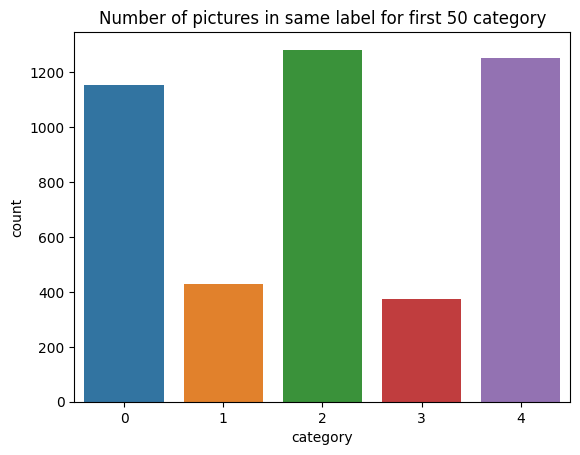

In [15]:
# Draw the bar chart of classe vs number of detection for first 50 record  of dataset
sns.barplot(x=label_group_df['category'][:50],y=label_group_df['count'][:50])
plt.title('Number of pictures in same label for first 50 category')

# This chart displys that the majority of detections are belong the classe 0, 2, 4

/tmp/ipykernel_219473/541426658.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.barplot(x=label_group_df['category'][-50:],y=label_group_df['count'][-50:])


Text(0.5, 1.0, 'Number of pictures in same label for last 50 category')

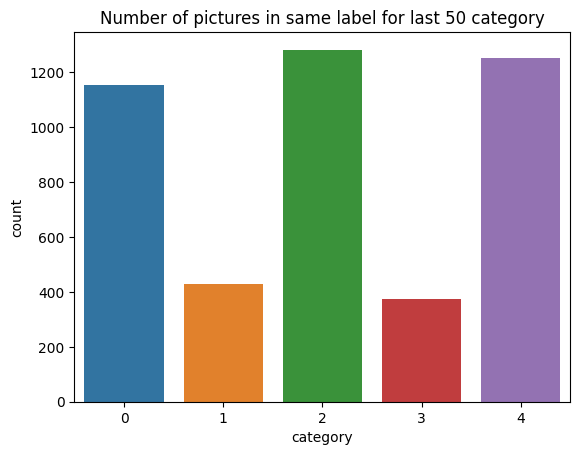

In [16]:
# Draw the bar chart of classe vs number of detection for last 50 record  of dataset
sns.barplot(x=label_group_df['category'][-50:],y=label_group_df['count'][-50:])
plt.title('Number of pictures in same label for last 50 category')

# This chart displys that the majority of detections are belong the classe 0, 2, 4

Text(0.5, 1.0, 'Number of pictures in same category')

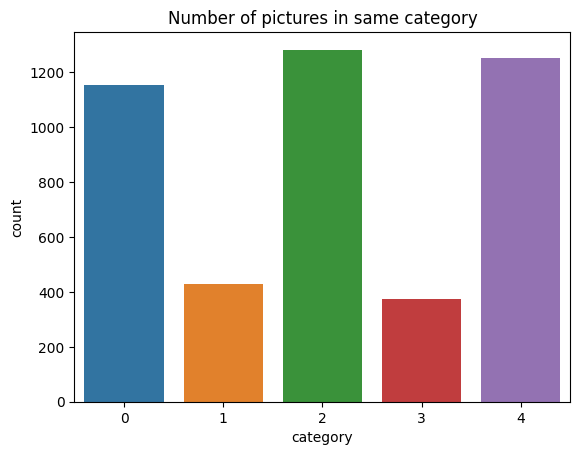

In [17]:
# Draw the bar chart of classe vs number of detection for the whole dataset
sns.barplot(x=label_group_df['category'],y=label_group_df['count'])
plt.title('Number of pictures in same category')

# This chart displys that the majority of detections are belong the classe 0, 2, 4
# Since all Three charts show steady proportion of classes it seems the classes are unified throught the whole dataset 

In [18]:
# This analysis to see if each detection has a unique "id" or not. 
var=train_csv[train_csv["id"].duplicated() == False].shape[0]
print('Number of uniqe id: ',var)

# since number of unique "id" is equal with number of detections then they are unique.

Number of uniqe id:  4491


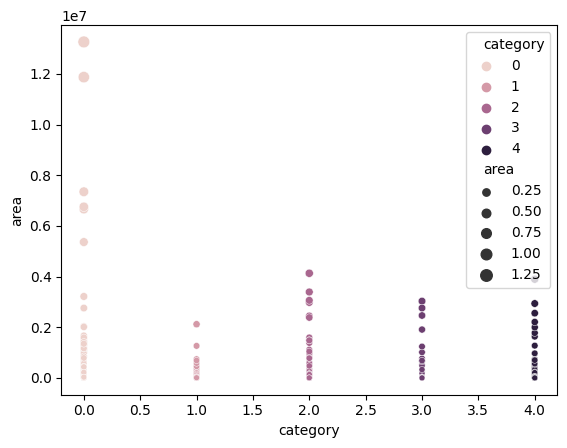

In [19]:
# This sccater plot is drawn to illustrate the relation between area of boundingbox and the detected class.
sns.scatterplot(data = train_csv, x = "category", y = "area", hue = "category", size = "area")

plt.show()

# According to the scatter plot, bigger areas are belong to class (0/Coverall). 
# Generally speaking, this make sese since between the classes, "coverall" objects
#  are most likely bigger than other other classes.  

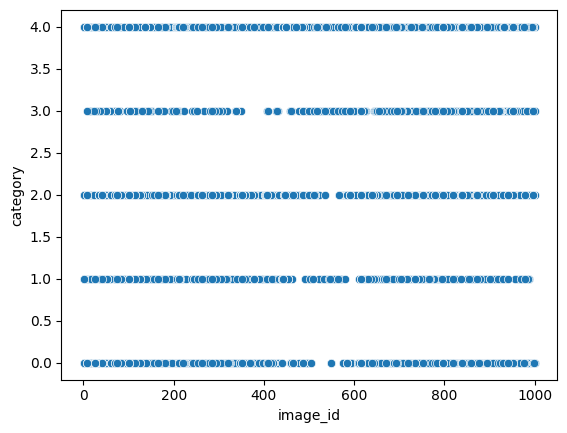

In [20]:
# This plot shows the each image at least has one detected objects.
sns.scatterplot(data = train_csv, x = "image_id", y = "category")

plt.show()

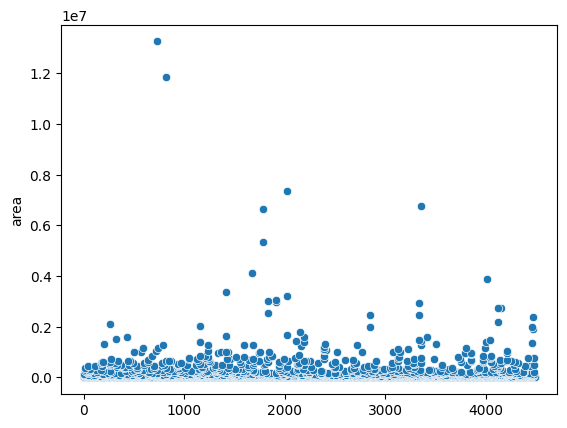

In [21]:
# This scatter plot represent the distribution of area of bboxes.  
sns.scatterplot(data = train_csv.area.sort_values())

plt.show()


# The biggest bbox's area is (1.2 * 1e7)
# The majority of areas are less than (0.2 * 1e7).
# A model trained by this dataset most likely fails to detect objects very close to camera,
#  yet it will show a better precision and recall detecting smaller objects. 

In [22]:
# Add another feature to our CSV file which is the center of each bounding box.
# Each center will be stored by a list of [x,y].
train_csv['bbox_center'] = train_csv.apply(lambda x: 
[(x['xmin'] + x['bbox_width']) / 2, (x['ymin'] + x['bbox_height']) / 2], axis=1)

In [23]:
# Add another feature to our CSV file which is the position of each bounding box by a list of [x,y].
# up-right objects are "Q1"
# up-left objects are "Q2"
# down-left objects are "Q3"
# down-right objects are "Q4"
train_csv['position'] = train_csv.apply(lambda x: 
'Q1' if x['bbox_center'][0] >= x['width'] / 2 and x['bbox_center'][1] <= x['height'] / 2 
else ('Q2' if x['bbox_center'][0] < x['width'] / 2 and x['bbox_center'][1] <= x['height'] / 2 
else ('Q3' if x['bbox_center'][0] < x['width'] / 2 and x['bbox_center'][1] > x['height'] / 2 
else 'Q4')), axis=1)

In [24]:
# compare "category" vs "position" to see which class appears in 
# what part of the image.
category_position_df = train_csv.groupby(['category', 'position'], as_index= False)['category'].count()
category_position_df.columns=['position', 'count']
category_position_df

,position,count
0,Q1,176
1,Q2,184
2,Q3,345
3,Q4,447
4,Q1,219
5,Q2,170
6,Q3,24
7,Q4,17
8,Q1,194
9,Q2,223


In [25]:
# compare "position" vs "category" to see which part of image appears in 
# what class.
position_category_df = train_csv.groupby(['position', 'category'], as_index= False)['position'].count()
position_category_df.columns=['category', 'count']
position_category_df


,category,count
0,0,176
1,1,219
2,2,194
3,3,195
4,4,551
5,0,184
6,1,170
7,2,223
8,3,157
9,4,478


In [26]:
# Joining two previous dataframe, this datafram show exacly the number of detection 
# happens in presence of a particular class and position.
df_cat_count_pos = pd.merge(category_position_df, position_category_df)
df_cat_count_pos = df_cat_count_pos.reindex(columns=['category','position', 'count'])
df_cat_count_pos

,category,position,count
0,0,Q1,176
1,0,Q2,184
2,0,Q3,345
3,0,Q4,447
4,1,Q1,219
5,1,Q2,170
6,1,Q3,24
7,1,Q4,17
8,2,Q1,194
9,2,Q2,223


/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/shahriar/anaconda3/envs/lemay/

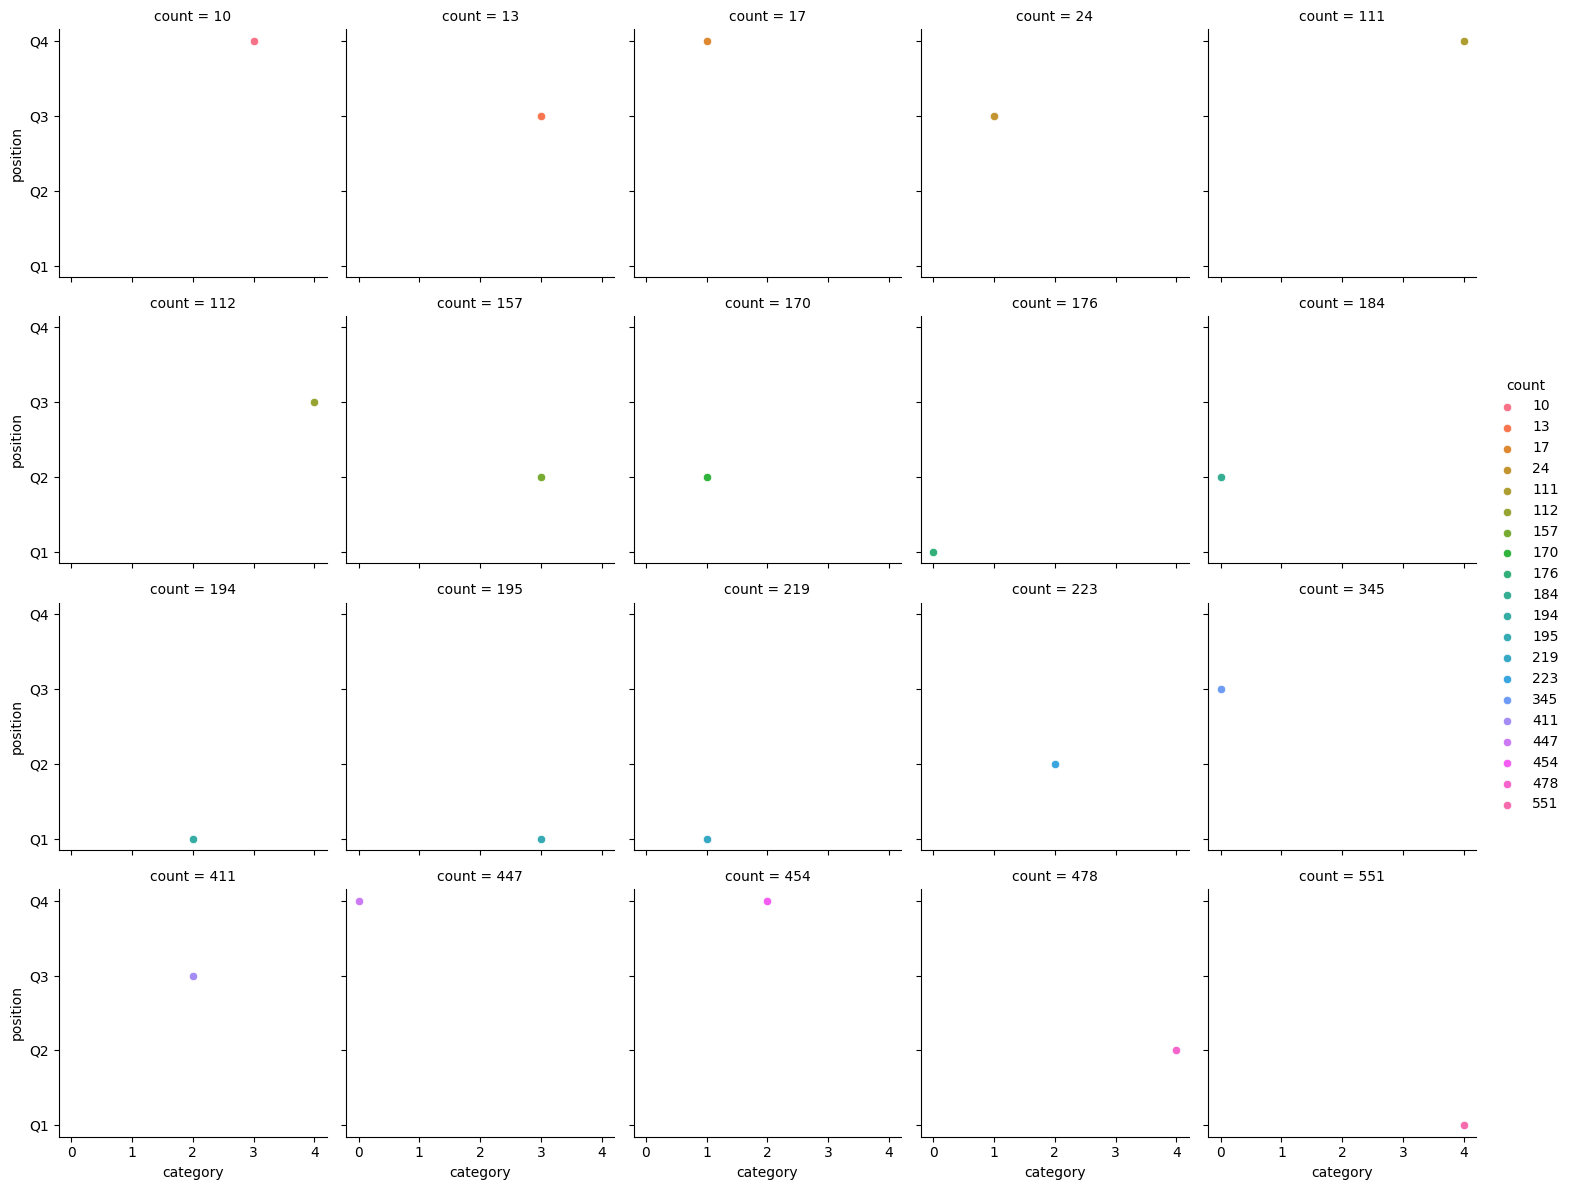

In [27]:
# each sub image of the below graph shows the number of detection belongs to specific claas
#  in a particular position.
grid = sns.FacetGrid(df_cat_count_pos, col = "count", hue = "count", col_wrap=5)
grid.map(sns.scatterplot, "category", "position")
grid.add_legend()
plt.show()

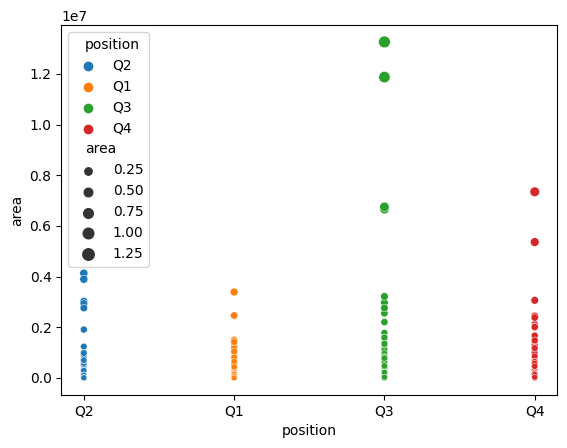

In [28]:
# This plot displays the area's bbox distribution in each position.
sns.scatterplot(data = train_csv, x = "position", y = "area", hue = "position", size = "area")

plt.show()

# According to the graph, areas bigger than (0.8 * 1e7) are located in "Q3" position.
# Having  said that and respect to area/class plot, the biggest area is belong to class 0 and located 
# in "Q3" position. 

In [29]:
# we are trying to run kmean analysis on 3 featurs 'area', 'position', 'category'.
kmeans_data = train_csv[['area', 'position', 'category']]
kmeans_data.head(10)

,area,position,category
0,3796,Q2,4
1,1596,Q1,4
2,152768,Q3,0
3,81002,Q1,0
4,17780,Q2,4
5,17500,Q1,4
6,11656,Q1,4
7,13320,Q3,2
8,1750,Q3,2
9,11136,Q3,2


In [31]:
# Normalize the continuous features in our data to ensure that one feature is not interpreted
#  as being more important than the other.
kmeans_norm = kmeans_data.copy()
scaler = preprocessing.MinMaxScaler()
kmeans_norm[['area']] = scaler.fit_transform(kmeans_norm[['area']])

In [32]:
# One hot encode the categorical values in our dataset using the pandas “get_dummies” function.
# One hot encoding involves creating a new column for each categorical value in the dataset.
#  Then a 1 or 0 is assigned depending on if that categorical value is in the data or not.
kmeans_norm = pd.get_dummies(kmeans_norm, columns=["position"])

In [33]:
# mplementation of K-means with 5 clusters
kmeans = KMeans(5)
clusters = kmeans.fit_predict(kmeans_norm)
labels = pd.DataFrame(clusters)
labeledCustomers = pd.concat((kmeans_data,labels),axis=1)
labeledCustomers = labeledCustomers.rename({0:'labels'},axis=1)

In [34]:
# printing the value of inertia
# Inertia measures how well a dataset was clustered by K-Means. 
# The lower values of inertia are better and zero is optimal.
print (kmeans.inertia_)

2621.19221668105


In [35]:
# feature vector
X = kmeans_data

# target variable
y = kmeans_data['category']

# Cluster centers
kmeans.cluster_centers_

array([[ 1.92162740e-02,  0.00000000e+00,  1.52777778e-01,
         1.59722222e-01,  2.99479167e-01,  3.88020833e-01],
       [ 4.16578571e-03,  1.98544699e+00, -1.66533454e-16,
         3.33066907e-16,  3.88578059e-16,  1.00000000e+00],
       [ 3.80617310e-03,  3.78818737e+00,  7.59674134e-01,
        -4.99600361e-16,  1.27291242e-01,  1.13034623e-01],
       [ 3.52907068e-03,  3.75275591e+00,  4.44089210e-16,
         1.00000000e+00,  4.16333634e-16,  2.77555756e-17],
       [ 3.56450333e-03,  1.66720387e+00,  3.32796132e-01,
         3.16680097e-01,  3.50523771e-01,  2.77555756e-16]])

In [36]:
# stroing labels
labels = kmeans.labels_

# check how many of the samples were correctly labeled
correct_labels = sum(y == labels)

# printing the results
print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))

Result: 1326 out of 4491 samples were correctly labeled.


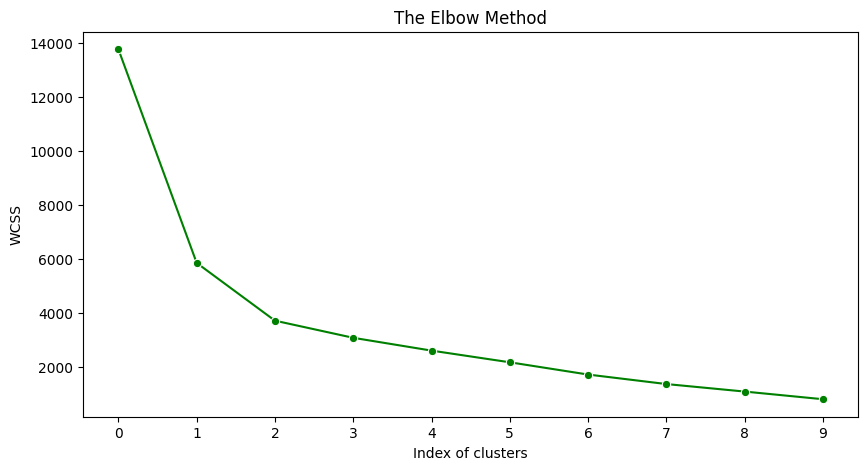

In [37]:
# Elbow analysis to find the optimal number of cluster 
# to store WCSS
wcss = []

# for loop 
for i in range(1, 11):
    
    # k-mean cluster model for different k values
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(kmeans_norm)
    
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

# figure size
plt.figure(figsize=(10,5))
sns.lineplot(wcss, marker='o',color='green')

# labeling
plt.title('The Elbow Method')
plt.xlabel('Index of clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(0, 10, 1.0))
plt.show()

# Based on Elbow graph, 3 clusters are the optimal number.

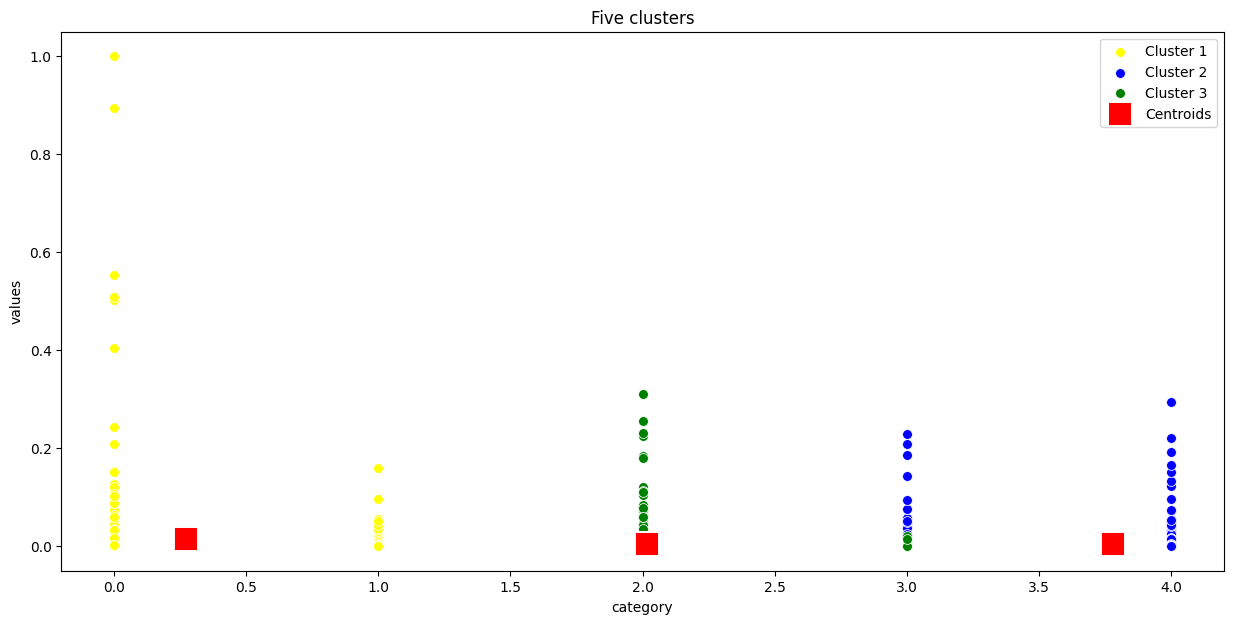

In [38]:
# k-mean algorithm
kmeans = KMeans(n_clusters = 3, random_state = 42)
y_kmeans = kmeans.fit_predict(kmeans_norm)
X = np.array(kmeans_norm)

# size of image
plt.figure(figsize=(15,7))

# visualizing the clusters
sns.scatterplot(y=X[y_kmeans == 0, 0], x=X[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(y=X[y_kmeans == 1, 0], x=X[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(y=X[y_kmeans == 2, 0], x=X[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
# sns.scatterplot(y=X[y_kmeans == 3, 0], x=X[y_kmeans == 3, 1], color = 'purple', label = 'Cluster 4',s=50)
# sns.scatterplot(y=X[y_kmeans == 4, 0], x=X[y_kmeans == 4, 1], color = 'black', label = 'Cluster 3',s=50)
sns.scatterplot(y=kmeans.cluster_centers_[:, 0], x=kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')

# labeling
# plt.grid(False)
plt.title('Five clusters')
plt.xlabel('category')
plt.ylabel('values')
plt.legend()
plt.show()


# As you can see in the graph, most of our data gathered around 3 clusters close to calss 0, 2, 4.
# This also supports our past analysis in bar plots representng the majority of detections are belong 
# those three classes.

In [39]:
# LDA is a linear transformation and is a supervised dimensionality reduction technique.
# This transformation is useful for imbalanced dataset since it pays attention to label.
# LDA tries to find a decision boundary around each cluster of a class.
lda_data = train_csv[['width', 'height','area', 'position', 'category']]

In [40]:
# Use min-max scaled data in the range (0, 1).
scaler = preprocessing.MinMaxScaler()
lda_data[['width', 'height', 'area']] = scaler.fit_transform(lda_data[['width', 'height', 'area']])

/tmp/ipykernel_219473/666219448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lda_data[['width', 'height', 'area']] = scaler.fit_transform(lda_data[['width', 'height', 'area']])


In [41]:
# One hot encode the categorical values in our dataset using the pandas “get_dummies” function.
lda_data = pd.get_dummies(lda_data, columns=["position"])

In [42]:
column_to_move = lda_data.pop("category")

# insert column with insert(location, column_name, column_value)

lda_data.insert(7, "category", column_to_move)

In [43]:
# X are the feature set 
# y is the label column. For our case it is "category"

X = lda_data.iloc[:, 0:7].values
y = lda_data.iloc[:, 7].values

In [44]:
# divides data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
# Perform LDA
# n_components = 1 refers to the number of linear discriminates that we want to retrieve.


lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

In [46]:
# To check performance of LDA with one linear discriminant, 
# a Random Forest classifier is used to evaluate performance


classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train_lda, y_train)
y_pred = classifier.predict(X_test_lda)

In [47]:
# Use confusion matrix to find the accuracy of the prediction

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy is {}%'.format(round(accuracy_score(y_test, y_pred) * 100)))

# You can see that with one linear discriminant, the algorithm achieved an accuracy of 47%.

[[114   0  61   0  57]
 [  4   0   2   0  79]
 [ 63   0  99   0  85]
 [  1   0   4   0  74]
 [ 18   0  32   0 206]]
Accuracy is 47%


In [48]:
# Train with whole feature set
classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [49]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy is {}%'.format(round(accuracy_score(y_test, y_pred) * 100)))

# You can see that with one linear discriminant, the algorithm achieved an accuracy of 59%.
# This means only one feature could reach the accuracy of 47% which is nearly 80% of the accuracy 
# achieved with the whole dataset.

[[204   0  14   0  14]
 [ 24   0   0   0  61]
 [ 48   0 130   0  69]
 [ 19   0   3   0  57]
 [ 36   0  23   0 197]]
Accuracy is 59%


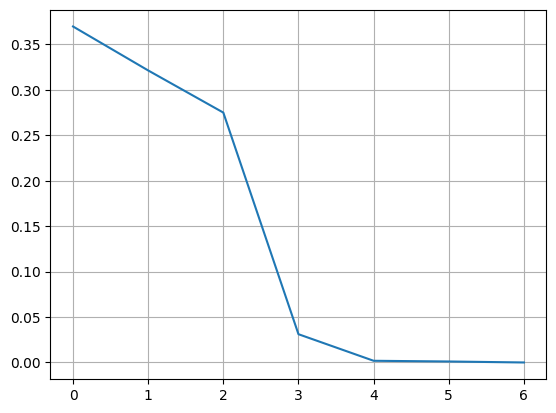

In [50]:
# PCA is an unsupervised dimensionality reduction technique.
# PCA, is a statistical technique to convert high dimensional data to low dimensional data by
#  selecting the most important features that capture maximum information about the dataset.

#The features are selected on the basis of variance that they cause in the output.
#  The feature that causes highest variance is the first principal component.

# The first principal component has lowest correlation with other components/features

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)
plt.grid(True)

# The graph beflow depicts principal components and their explained variance value
#  more than 95% .

In [51]:
sorted(explained_variance, reverse=True)

[0.3696877555260869,
 0.3213073846300746,
 0.2749476230767533,
 0.03109856409657179,
 0.0018638982783604446,
 0.001094774392152993,
 4.31509264075514e-32]

In [52]:
print("First 3 components are responsible for {}% of dataset variance".format(round((sum(explained_variance[:3])
 / sum(explained_variance)) * 100)))

First 3 components are responsible for 97% of dataset variance


In [53]:
# Perform PCA with 3 principal components 
# n_components = 3 refers to the number of principal components that we want to retrieve.
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [54]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_pca, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test_pca)

In [55]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy is {}%'.format(round(accuracy_score(y_test, y_pred) * 100)))

# With 3 principal components the classification accuracy is 46%.
# This means with 3 principal components,we could reach the accuracy of 46% which is nearly
#  80% of the accuracy achieved with the whole dataset.

[[ 42   0 125   0  65]
 [  2   0   3   0  80]
 [  3   0 159   0  85]
 [  0   0   5   0  74]
 [  6   0  41   0 209]]
Accuracy is 46%


In [57]:
# An encoder-decoder network is an unsupervised artificial neural model that consists of
#  an encoder component and a decoder one.
# An autoencoder is a technique for neural networks that learns efficient data 
# representations (encoding) by training the network to ignore signal “noise.”

# Squeeze the 7-dimensional space into a 3-dimensional latent space
# This is the dimension of the original space
input_dim = 7

# This is the dimension of the latent space (encoding space)

latent_dim = 2

encoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(64, activation='relu', input_shape=(latent_dim,)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(input_dim, activation=None)
])

2022-09-28 03:43:47.574663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shahriar/anaconda3/envs/lemay/lib/python3.8/site-packages/cv2/../../lib64:
2022-09-28 03:43:47.574712: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 03:43:47.574734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shahriar-VirtualBox): /proc/driver/nvidia/version does not exist
2022-09-28 03:43:47.576684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


![convert notebook to web app](https://ekamperi.github.io/images/autoencoder/autoencoder_schematic.png)

In [58]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

/tmp/ipykernel_219473/1839881679.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[i].set_xticklabels(metric_names)


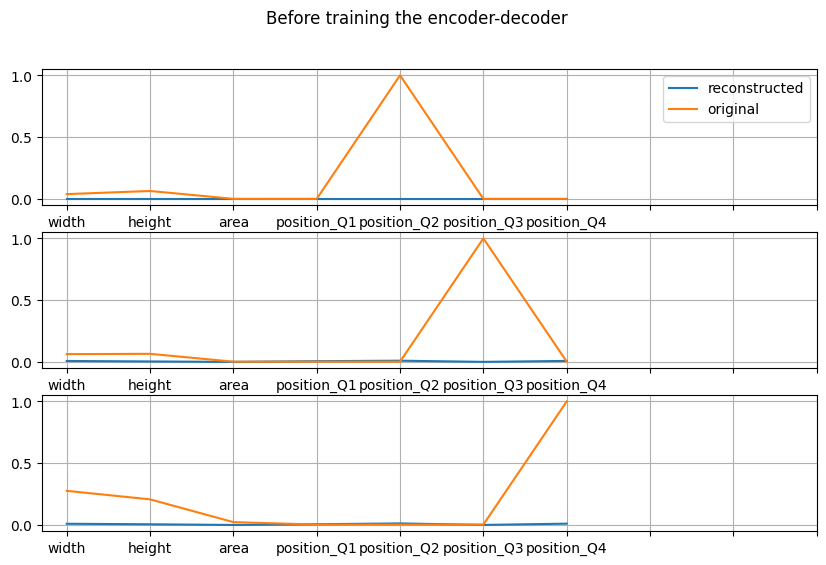

In [59]:
# At this point, our autoencoder has not been trained yet. Let’s feed it with some examples
#  from the dataset and see how well it performs in reconstructing the input.
metric_names = lda_data.columns[:-1]
def plot_orig_vs_recon(title='', n_samples=3):
    fig = plt.figure(figsize=(10,6))
    plt.suptitle(title)
    for i in range(3):
        plt.subplot(3, 1, i+1)
        idx = random.sample(range(X_train.shape[0]), 1)
        plt.plot(autoencoder.predict(X_train[idx]).squeeze(), label='reconstructed' if i == 0 else '')
        plt.plot(X_train[idx].squeeze(), label='original' if i == 0 else '')
        fig.axes[i].set_xticklabels(metric_names)
        plt.xticks(np.arange(0, 10, 1))
        plt.grid(True)
        if i == 0: 
            plt.legend()

plot_orig_vs_recon('Before training the encoder-decoder')

# As you can see all of the autoencouder prediction is 0 before training.

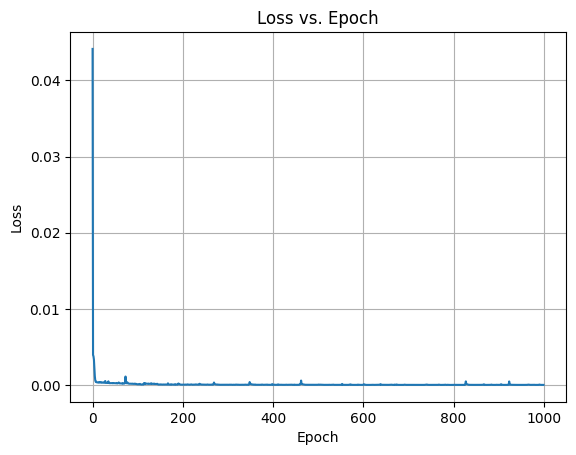

In [60]:
# train the model for 1000 epochs and check the loss vs. epoch to make sure that it converged
model_history = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, verbose=0)

plt.plot(model_history.history["loss"])
plt.title("Loss vs. Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.grid(True)

# The optimizer converged

/tmp/ipykernel_219473/1839881679.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[i].set_xticklabels(metric_names)


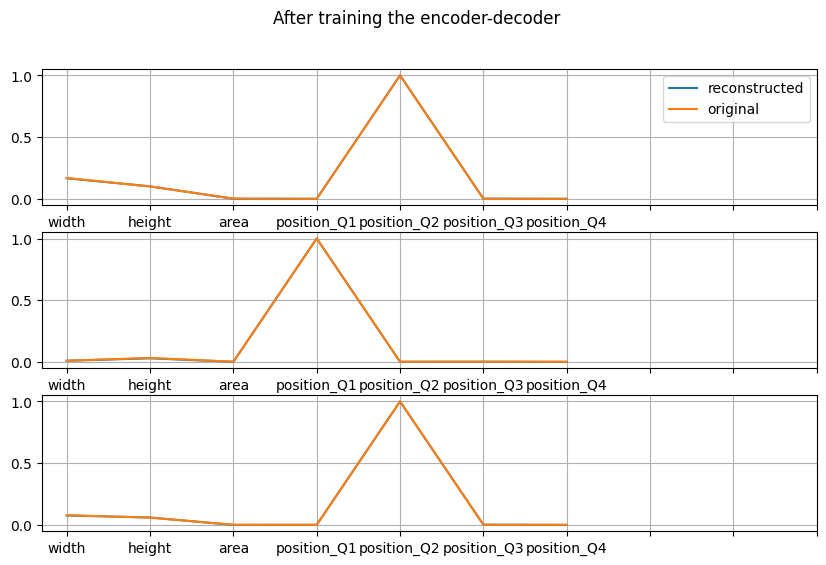

In [61]:
# check again how well the autoencoder can reconstruct its input.
plot_orig_vs_recon('After training the encoder-decoder')

# The reconstructed values are very close to the original ones. The result support the convergence graph. 

Text(0, 0.5, 'Latent Dimension 2')

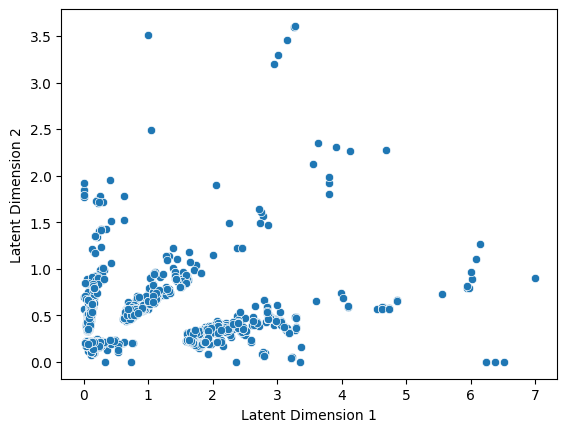

In [65]:
# This is the projection of the 7-dimensional data onto a plane.
encoded_x_train = encoder(X_train)
sns.scatterplot(x=encoded_x_train[:, 0], y=encoded_x_train[:, 1])
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# This 2D imprint is all it takes for the decoder to regenerate the initial 7-dimensional space.
# Ideally, we would like each class’s data points to form distinct clusters in a classification scenario.
# The garph depicts 3 different clusters which are same as 3 classes (0, 2, 4) with major number of detections.